In [5]:
from aostools.climate import GlobalAvg, eof
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [6]:
def ComputeAnnularMode(lat, pres, data, choice='z', hemi='infer', detrend='constant', eof_in=None, pc_in=None, eof_out=False, pc_out=False):
	"""Compute annular mode as in Gerber et al, GRL 2008.
		This is basically the first PC, but normalized to unit variance and zero mean.
		To conform to Gerber et al (2008), `data` should be anomalous height or zonal wind
		 with respect to 30-day smoothed day of year climatology.
		INPUTS:
			lat    - latitude
			pres   - pressure
			data   - variable to compute EOF from. This is typically
						geopotential or zonal wind.
						Size time x pres x lat (ie zonal mean)
			choice - not essential, but used for sign convention.
						If 'z', the sign is determined based on 70-80N/S.
						Otherwise, 50-60N/S is used.
			hemi   - hemisphere to consider
						'infer' - if mean(lat)>=0 -> NH, else SH
						'SH' or 'NH'
			detrend- detrend method for computing EOFs:
						'linear' -> remove linear trend
						'constant' -> remove total time mean
			eof_in - if None, compute EOF1 as usual.
					 if the EOF1 is already known, use this instead of
				    computing it again.
			pc_in  - if None, standardize PC1 to its own mean and std deviation
				 else, use pc_in mean and std deviation to standardize.
			eof_out- whether or not to pass the first EOF as output [False].
			pc_out - whether or not to pass the first PC as output [False].
		OUTPUT:
			AM     - The annular mode, size time x pres
			EOF    - The first EOF (if eof_out is True), size pres x lat
			PC     - The first PC (if pc_out is True). size time x pres
	"""
	#
	AM = np.full((data.shape[0],data.shape[1]),np.nan)
	if pc_out:
		pco = np.full(AM.shape,np.nan)
	# guess the hemisphere
	if hemi == 'infer':
		if np.mean(lat) >= 0:
			sgn = 1.
		else:
			sgn = -1.
	elif hemi == 'SH':
		sgn = -1.
	elif hemi == 'NH':
		sgn = 1.
	j_tmp = np.where(sgn*lat > 20)[0]
	if eof_out:
		eofo = np.full((data.shape[1],len(j_tmp)),np.nan)
	coslat = np.cos(np.deg2rad(lat))
	negCos = (coslat < 0.)
	coslat[negCos] = 0.
	# weighting as in Gerber et al GRL 2008
	sqrtcoslat = np.sqrt(coslat[j_tmp])
	# try to get the sign right
	# first possibility
	if choice == 'z':
		minj = min(sgn*70,sgn*80)
		maxj = max(sgn*80,sgn*70)
		sig = -1
	else:
		minj = min(sgn*50,sgn*60)
		maxj = max(sgn*60,sgn*50)
		sig = 1
	jj = (lat[j_tmp] > minj)*(lat[j_tmp] < maxj)
	# second possibility
	#jj = abs(lat[j_tmp]-80).argmin()
	#sig = -1
	if isinstance(pres,(int,float)):
		data = np.reshape(data,(data.shape[0],1,data.shape[1]))
		pres = [pres]
	E_ls = []
	for k, p in enumerate(pres):
		# remove global mean
		globZ = GlobalAvg(lat,data[:,k,:],axis=-1,lim=lat[j_tmp[0]],mx=lat[j_tmp[-1]])
		var = data[:,k,:] - globZ[:,np.newaxis]
		# area weighting: EOFs are ~variance, thus take sqrt(cos)
		var = var[:,j_tmp]*sqrtcoslat[np.newaxis,:]
		varNan = np.isnan(var)
		if np.sum(np.reshape(varNan,(np.size(varNan),)))==0:
			if eof_in is None:
				eof1,pc1,E,u,s,v = eof(var,n=1,detrend=detrend)
				print(p, E)
				E_ls.append(E)
			else:
				pc1 = eof(var,n=1,detrend=detrend,eof_in=eof_in[k,:])
				eof1 = eof_in[k,:]
			# force the sign of PC
			pc1  = pc1*sig*np.sign(eof1[jj].mean())
			if eof_out:
				eofo[k,:] = np.squeeze(eof1)
			if pc_out:
				pco[:,k] = pc1
			# force unit variance and zero mean
			if pc_in is None:
				AM[:,k] = (pc1-pc1.mean())/np.std(pc1)
			else:
				AM[:,k] = (pc1-pc_in.mean())/np.std(pc_in)
	if eof_out and pc_out:
		return AM,eofo,pco
	elif eof_out:
		return AM,eofo
	elif pc_out:
		return AM,pco
	else:
		return AM,E_ls

In [7]:
root_path = '/mnt/data04/model/CMAM/0A.daily/'
label_ls = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I','J','K','L']
its = 10000
plt.rcParams.update({'font.size': 22})
sns.set_style('whitegrid')

In [8]:
ds = xr.open_dataset(f'{root_path}ua/ua_6hrPlev_CMAM_CMAM30-SD_r1i1p1_19790101-20101231_anomalies_zm.nc')#.dropna('time', how='all')
#ds = ds.where(np.isfinite(ds), drop = True)
ds['plev'] = ds.plev/100.
ds['plev'].attrs['units'] = 'hPa'
ds['plev'].attrs['long_name'] = 'pressure'
ds_sel = ds.sel(lat = slice(0,None))
"""mask =  (ds.time.dt.month == 12) | \
    (ds.time.dt.month == 1) | (ds.time.dta.month == 2) #| (ds.time.dt.month == 3)

ds_sel = ds_sel.where(np.isfinite(ds_sel), drop = True)
#ds['time'] = xr.cftime_range('1979-01-01T06', '2010-12-31T18', freq='6H', calendar='noleap')
ds_sel"""
ds

<xarray.Dataset>
Dimensions:  (lat: 48, plev: 63, time: 46720)
Coordinates:
  * plev     (plev) float64 1e+03 925.0 850.0 800.0 ... 0.0015 0.001 0.0007
  * lat      (lat) float64 -87.16 -83.48 -79.78 -76.07 ... 79.78 83.48 87.16
  * time     (time) datetime64[ns] 1997-01-01 ... 1990-12-31T18:00:00
    month    (time) int64 ...
Data variables:
    ua       (time, plev, lat) float64 ...

In [9]:
am_arr, E_arr = ComputeAnnularMode(ds_sel.lat.values, ds_sel.plev.values, ds_sel.ua.values, \
                            choice = 'u')

1000.0 [0.28495444]
925.0 [0.30510426]
850.0 [0.32292304]
800.0 [0.32680078]
780.0 [0.32714974]
750.0 [0.32704052]
700.0 [0.32531014]
650.0 [0.32204996]
600.0 [0.31742462]
500.0 [0.30552052]
450.0 [0.29916022]
400.0 [0.29359553]
350.0 [0.29007271]
300.0 [0.29048437]
285.0 [0.29121662]
250.0 [0.298128]
200.0 [0.32699982]
170.0 [0.36207709]
150.0 [0.39198185]
130.0 [0.42966897]
115.0 [0.46788942]
100.0 [0.5194843]
90.0 [0.56116193]
80.0 [0.60726204]
70.0 [0.65351635]
60.0 [0.6937017]
50.0 [0.72235427]
40.0 [0.73607915]
35.0 [0.73605411]
30.0 [0.73239803]
25.0 [0.72295168]
20.0 [0.71103766]
15.0 [0.69501598]
10.0 [0.68500942]
7.0 [0.67964719]
5.0 [0.68075764]
4.0 [0.67947005]
3.0 [0.67637964]
2.0 [0.66802664]
1.5 [0.66233281]
1.0 [0.65697891]
0.7 [0.64779029]
0.5 [0.63269287]
0.4 [0.62212502]
0.3 [0.60574766]
0.2 [0.58338721]
0.15 [0.56965028]
0.1 [0.55277931]
0.07 [0.54189023]
0.05 [0.53353867]
0.04 [0.53167376]
0.03 [0.52109934]
0.02 [0.5092943]
0.015 [0.5025293]
0.01 [0.5083152]
0.0070

In [11]:
am_arr.shape

(46720, 63)

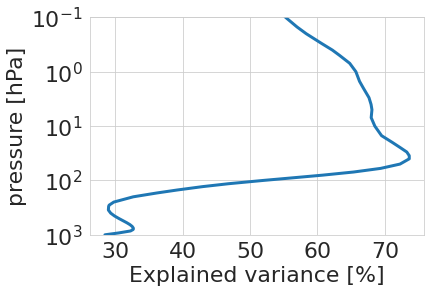

In [12]:
plt.plot(np.array(E_arr)*100, ds_sel.plev.values, lw = 3)
plt.yscale('log')
plt.ylabel('pressure [hPa]')
plt.xlabel('Explained variance [%]')
plt.ylim(1000,0.1)
plt.savefig('NAM_explained_variance.pdf', bbox_inches='tight')